In [ ]:
!pip install tensorflow


In [ ]:
# @title Package installation

import gdown
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import tensorflow.keras.metrics as metrics
import tensorflow as tf
from google.colab import drive
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import plot_model
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.models import load_model
from tensorflow.keras.losses import mse
from tensorflow.keras.callbacks import ReduceLROnPlateau

In [ ]:
# Mount Google Drive
drive.mount('/content/drive', force_remount=True)

data_path = '/content/drive/MyDrive/data_percobaan/Data/xlsx/Ramp.xlsx'

data = pd.read_excel(data_path)

data.info()

Mounted at /content/drive
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1203 entries, 0 to 1202
Data columns (total 3 columns):
 #   Column                        Non-Null Count  Dtype
---  ------                        --------------  -----
 0   Frequency (Hz)                1203 non-null   int64
 1   Signal Characteristic (dBuV)  1203 non-null   int64
 2   EMI (dBuV)                    1203 non-null   int64
dtypes: int64(3)
memory usage: 28.3 KB


In [ ]:
# Read CSV as dataframe (df)
data.head()

,Frequency (Hz),Signal Characteristic (dBuV),EMI (dBuV)
0,150000,81,71
1,224625,83,68
2,299250,83,66
3,373875,83,61
4,448500,83,77


Frequency:
 Frequency (Hz)
150000      3
19851000    3
20597250    3
20522625    3
20448000    3
           ..
9925875     3
9851250     3
9776625     3
9702000     3
30000000    3
Name: count, Length: 401, dtype: int64

Characteristics:
 count    1203.000000
mean       34.725686
std        15.003812
min        13.000000
25%        25.000000
50%        30.000000
75%        40.000000
max        83.000000
Name: Signal Characteristic (dBuV), dtype: float64


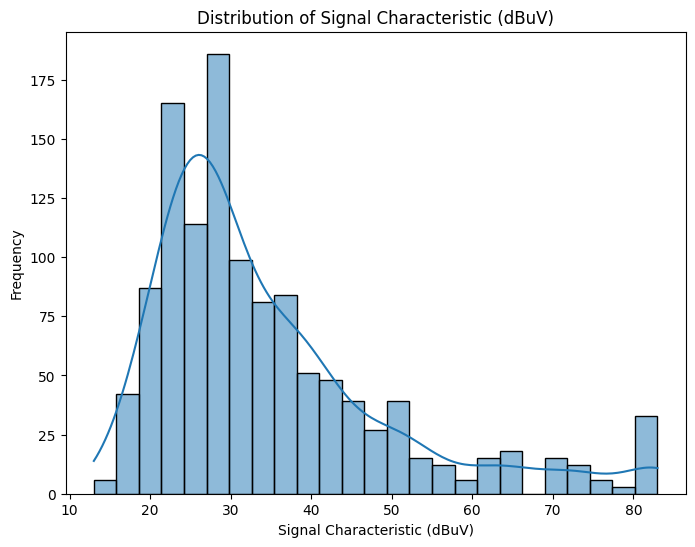

In [ ]:
frequency = data['Frequency (Hz)'].value_counts()
print("Frequency:\n", frequency)

characteristics = data['Signal Characteristic (dBuV)'].describe()
print("\nCharacteristics:\n", characteristics)

plt.figure(figsize=(8, 6))
sns.histplot(data['Signal Characteristic (dBuV)'], kde=True)
plt.title('Distribution of Signal Characteristic (dBuV)')
plt.xlabel('Signal Characteristic (dBuV)')
plt.ylabel('Frequency')
plt.show()


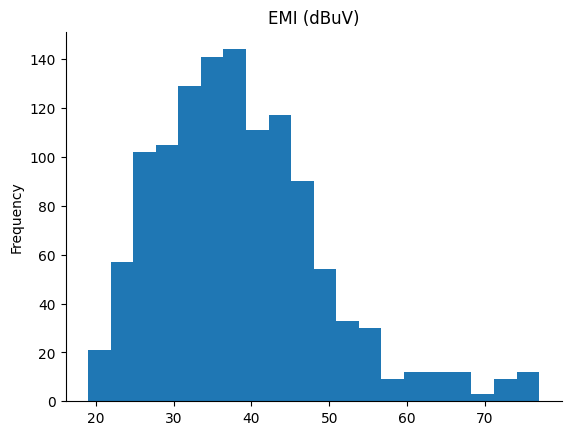

In [ ]:
# @title EMI (dBuV)

from matplotlib import pyplot as plt
data['EMI (dBuV)'].plot(kind='hist', bins=20, title='EMI (dBuV)')
plt.gca().spines[['top', 'right',]].set_visible(False)

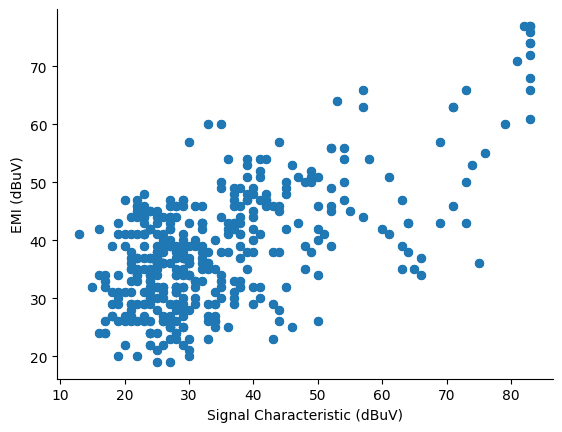

In [ ]:
# @title Signal Characteristic (dBuV) vs EMI (dBuV)

from matplotlib import pyplot as plt
data.plot(kind='scatter', x='Signal Characteristic (dBuV)', y='EMI (dBuV)', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

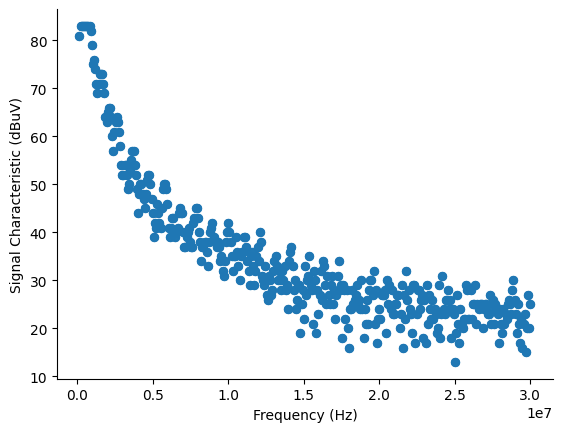

In [ ]:
# @title Frequency (Hz) vs Signal Characteristic (dBuV)

from matplotlib import pyplot as plt
data.plot(kind='scatter', x='Frequency (Hz)', y='Signal Characteristic (dBuV)', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

In [ ]:
# Check the data types
data.dtypes

,0
Frequency (Hz),int64
Signal Characteristic (dBuV),int64
EMI (dBuV),int64


In [ ]:
data.isnull().sum()

,0
Frequency (Hz),0
Signal Characteristic (dBuV),0
EMI (dBuV),0


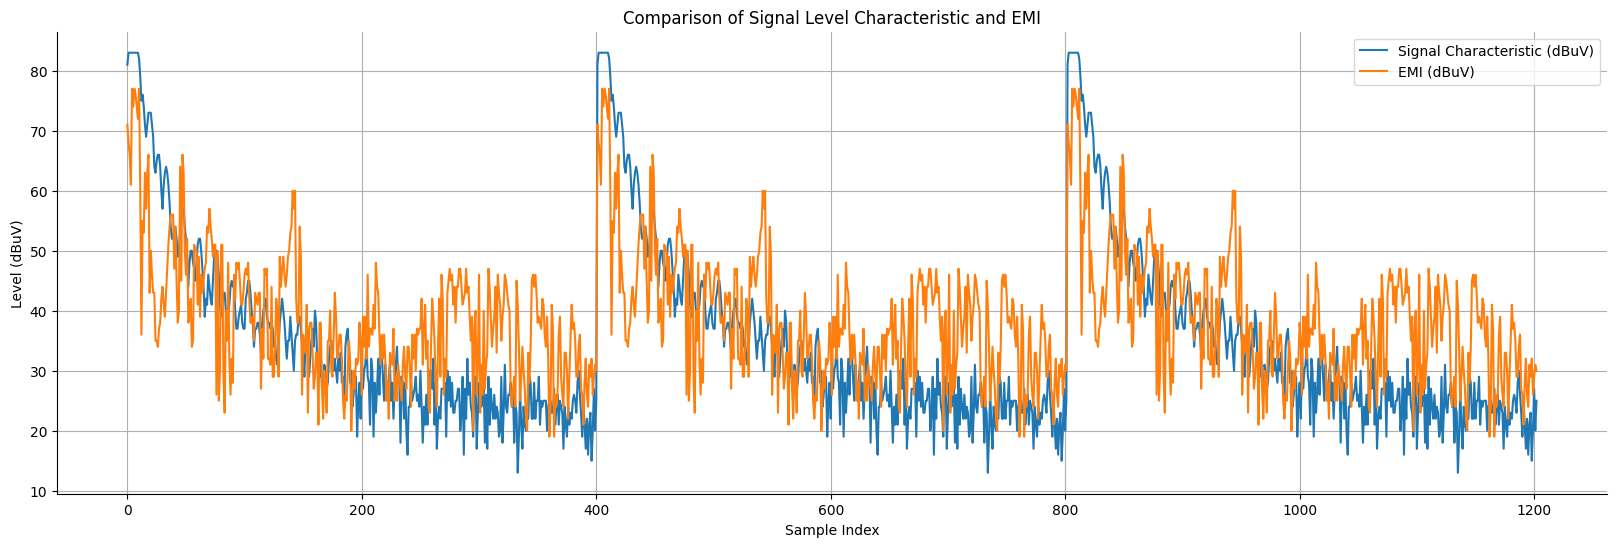

In [ ]:
plt.figure(figsize=(20, 6))  # Adjust figure size as needed

# Plot Signal Characteristic
plt.plot(data['Signal Characteristic (dBuV)'], label='Signal Characteristic (dBuV)')

# Plot EMI
plt.plot(data['EMI (dBuV)'], label='EMI (dBuV)')

plt.xlabel("Sample Index") # Assuming the index represents time or sample number
plt.ylabel("Level (dBuV)")
plt.title("Comparison of Signal Level Characteristic and EMI")
plt.legend()
plt.grid(True)
plt.gca().spines[['top', 'right']].set_visible(False)
plt.show()


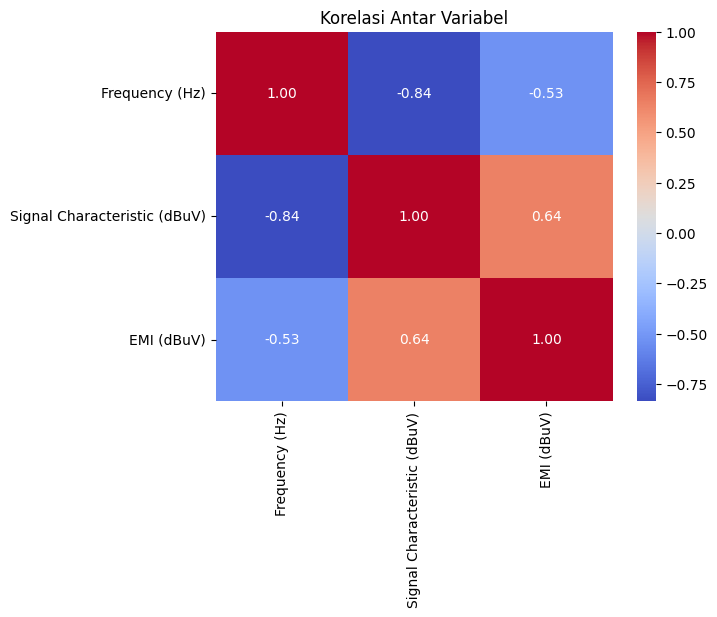

In [ ]:
# Calculate the correlation matrix
correlation_matrix = data[['Frequency (Hz)','Signal Characteristic (dBuV)','EMI (dBuV)']].corr()

# Heatmap
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Korelasi Antar Variabel')
plt.show()


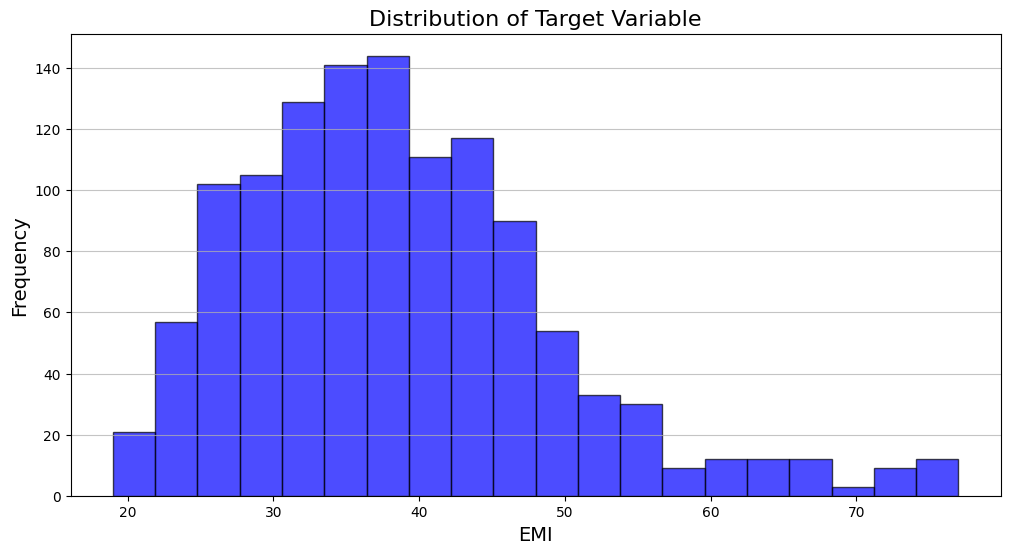

In [ ]:
# Analysis of dataset distribution
plt.figure(figsize=(12, 6))
plt.hist(data['EMI (dBuV)'], bins=20, color='blue', alpha=0.7, edgecolor='black')
plt.title("Distribution of Target Variable", fontsize=16)
plt.xlabel("EMI", fontsize=14)
plt.ylabel("Frequency", fontsize=14)
plt.grid(axis='y', alpha=0.75)
plt.show()

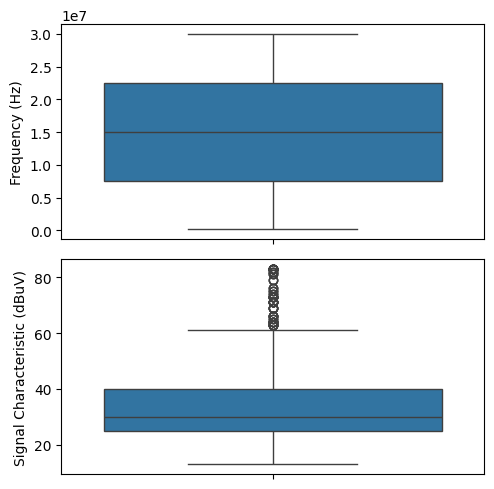

In [ ]:
ffig, axs = plt.subplots(2, figsize = (5,5))
plt1 = sns.boxplot(data['Frequency (Hz)'], ax = axs[0])
plt2 = sns.boxplot(data['Signal Characteristic (dBuV)'], ax = axs[1])
plt.tight_layout()

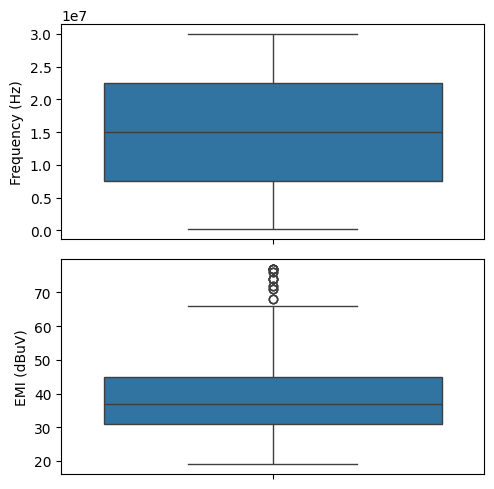

In [ ]:
ffig, axs = plt.subplots(2, figsize = (5,5))
plt1 = sns.boxplot(data['Frequency (Hz)'], ax = axs[0])
plt2 = sns.boxplot(data['EMI (dBuV)'], ax = axs[1])
plt.tight_layout()

In [ ]:
# @title Pengecekan Error
data = data.apply(pd.to_numeric, errors='coerce')

data.dropna(inplace=True)

In [ ]:
# @title Pembagian Data
X = data[["Frequency (Hz)","Signal Characteristic (dBuV)"]]
y = data["EMI (dBuV)"]

In [ ]:
#@title Split Data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=100)

In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif_data = pd.DataFrame()
vif_data["Feature"] = X_train.columns
vif_data["VIF"] = [variance_inflation_factor(X_train.values, i) for i in range(X_train.shape[1])]
print(vif_data)


                        Feature       VIF
0                Frequency (Hz)  1.665797
1  Signal Characteristic (dBuV)  1.665797


In [ ]:
# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
#@title Model MLR
lin_reg = LinearRegression()
lin_reg.fit(X_train_scaled, y_train)

y_pred_lr = lin_reg.predict(X_test_scaled)

X_train_nn = np.hstack((X_train_scaled, lin_reg.predict(X_train_scaled).reshape(-1, 1)))
X_test_nn = np.hstack((X_test_scaled, y_pred_lr.reshape(-1, 1)))

lr_mse = mean_squared_error(y_test, y_pred_lr)
lr_r2 = r2_score(y_test, y_pred_lr)
lr_mae = mean_absolute_error(y_test, y_pred_lr)
lr_mape = mean_absolute_percentage_error(y_test, y_pred_lr)
n = X_test_scaled.shape[0]
k = X_test_scaled.shape[1]
lr_adj_r2 = 1 - ((1 - lr_r2) * (n - 1) / (n - k - 1))
print(f"Linear Regression MSE: {lr_mse:.4f}")
print(f"Linear Regression R2: {lr_r2:.4f}")
print(f"Linear Regression MAE: {lr_mae:.4f}")
print(f"Linear Regression MAPE: {lr_mape*100:.4f}%")
print(f"Linear Regression Adjusted R2: {lr_adj_r2:.4f}")

model = Sequential([
    Dense(256, input_dim=X_train_nn.shape[1], activation='relu'),
    BatchNormalization(),
    Dropout(0.2),

    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.2),

    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.2),

    Dense(32, activation='relu'),
    BatchNormalization(),
    Dropout(0.2),

    Dense(16, activation='linear'),
    BatchNormalization(),
    Dropout(0.2),

    Dense(1)
])

model.compile(optimizer='adam', loss='mse', metrics=['mae'])

history = model.fit(
    X_train_nn, y_train,
    epochs=500,
    batch_size=32,
    validation_split=0.2,
    verbose=1
)

y_pred_nn = model.predict(X_test_nn, steps=len(X_test_nn))
nn_mse = mean_squared_error(y_test, y_pred_nn)
nn_r2 = r2_score(y_test, y_pred_nn)
nn_mae = mean_absolute_error(y_test, y_pred_nn)
nn_mape = mean_absolute_percentage_error(y_test, y_pred_nn)
n_nn = X_test_nn.shape[0]
k_nn = X_test_nn.shape[1]
nn_adj_r2 = 1 - ((1 - nn_r2) * (n_nn - 1) / (n_nn - k_nn - 1))
print(f"Neural Network MSE: {nn_mse:.4f}")
print(f"Neural Network R2: {nn_r2:.4f}")
print(f"Neural Network MAE: {nn_mae:.4f}")
print(f"Neural Network MAPE: {nn_mape*100:.4f}%")
print(f"Neural Network Adjusted R2: {nn_adj_r2:.4f}")

np.save('y_test.npy', y_test)
np.save('y_pred_nn.npy', y_pred_nn)

model.save('model_emi.h5')

Linear Regression MSE: 76.8373
Linear Regression R2: 0.3277
Linear Regression MAE: 7.2980
Linear Regression MAPE: 21.0474%
Linear Regression Adjusted R2: 0.3240
Epoch 1/500


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


22/22 ━━━━━━━━━━━━━━━━━━━━ 7s 32ms/step - loss: 1558.2372 - mae: 37.9854 - val_loss: 1479.3496 - val_mae: 36.8821
Epoch 2/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 1548.8077 - mae: 38.2361 - val_loss: 945.3011 - val_mae: 29.3152
Epoch 3/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1549.1644 - mae: 38.1907 - val_loss: 942.8477 - val_mae: 29.4079
Epoch 4/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 1522.3372 - mae: 37.8904 - val_loss: 962.9714 - val_mae: 29.8391
Epoch 5/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 1460.8119 - mae: 37.3207 - val_loss: 970.5685 - val_mae: 30.0672
Epoch 6/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1476.7405 - mae: 37.4336 - val_loss: 972.3787 - val_mae: 30.1670
Epoch 7/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1505.9208 - mae: 37.7850 - val_loss: 998.8256 - val_mae: 30.6065
Epoch 8/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1415.7623 - mae: 36.7102 - val_loss: 1087.3652 - val_mae: 32.0101
Epoch 9/500
2

Neural Network MSE: 62.6745
Neural Network R2: 0.4517
Neural Network MAE: 6.4385
Neural Network MAPE: 18.4317%
Neural Network Adjusted R2: 0.4470


In [ ]:
# @title Hasil Semua Evaluasi
print("\nSummary:")
print(f"Linear Regression MSE: {lr_mse:.4f}")
print(f"Linear Regression R2: {lr_r2:.4f}")
print(f"Linear Regression MAE: {lr_mae:.4f}")
print(f"Linear Regression MAPE: {lr_mape*100:.4f}%")
print(f"Linear Regression Adjusted R2: {lr_adj_r2:.4f}")
print(f"---------------------------------------------------------------------")
print(f"Neural Network MSE: {nn_mse:.4f}")
print(f"Neural Network R2: {nn_r2:.4f}")
print(f"Neural Network MAE: {nn_mae:.4f}")
print(f"Neural Network MAPE: {nn_mape*100:.4f}%")
print(f"Neural Network Adjusted R2: {nn_adj_r2:.4f}")



Summary:
Linear Regression MSE: 76.8373
Linear Regression R2: 0.3277
Linear Regression MAE: 7.2980
Linear Regression MAPE: 21.0474%
Linear Regression Adjusted R2: 0.3240
---------------------------------------------------------------------
Neural Network MSE: 62.6745
Neural Network R2: 0.4517
Neural Network MAE: 6.4385
Neural Network MAPE: 18.4317%
Neural Network Adjusted R2: 0.4470


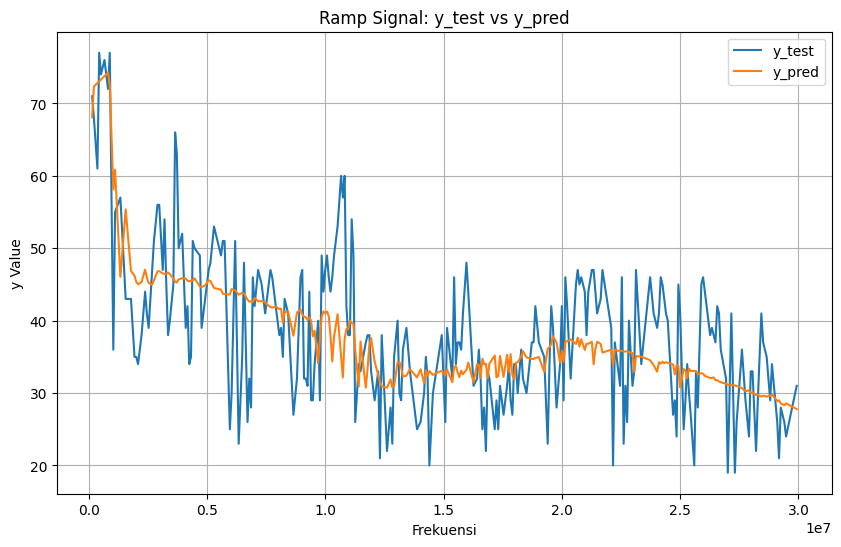

In [ ]:
# Load the saved data
y_test = np.load('y_test.npy')
y_pred_nn = np.load('y_pred_nn.npy')

test_indices = X_test.index

# Get the corresponding 'Frekuensi' values for the test set
frekuensi = data['Frequency (Hz)'].loc[test_indices].values

# Sort data based on frekuensi in ascending order
sorted_indices = np.argsort(frekuensi)
frekuensi_sorted = frekuensi[sorted_indices]
y_test_sorted = y_test[sorted_indices]
y_pred_nn_sorted = y_pred_nn.flatten()[sorted_indices]

# Create the line plot
plt.figure(figsize=(10, 6))
plt.plot(frekuensi_sorted, y_test_sorted, label='y_test', marker='', linestyle='-')
plt.plot(frekuensi_sorted, y_pred_nn_sorted, label='y_pred', marker='', linestyle='-')

plt.xlabel('Frekuensi')
plt.ylabel('y Value')
plt.title('Ramp Signal: y_test vs y_pred')
plt.legend()
plt.grid(True)
plt.show()

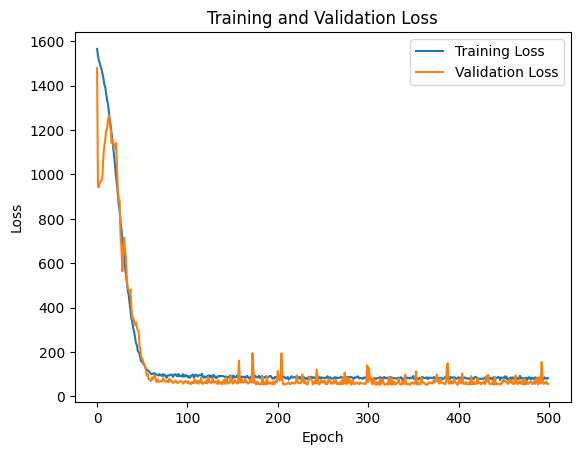

In [ ]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


In [ ]:
# Print model summary
print("Model Summary:")
model.summary()

Model Summary:


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_47 (Dense)                     │ (None, 256)                 │           1,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_10               │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_48 (Dense)                     │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_11               │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_11 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_49 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_12               │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_12 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_50 (Dense)                     │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_13               │ (None, 32)                  │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_13 (Dropout)                 │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_51 (Dense)                     │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_14               │ (None, 16)                  │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_14 (Dropout)                 │ (None, 16)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_52 (Dense)                     │ (None, 1)                   │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 138,373 (540.52 KB)

 Trainable params: 45,793 (178.88 KB)

 Non-trainable params: 992 (3.88 KB)

 Optimizer params: 91,588 (357.77 KB)

In [ ]:
pip install networkx matplotlib


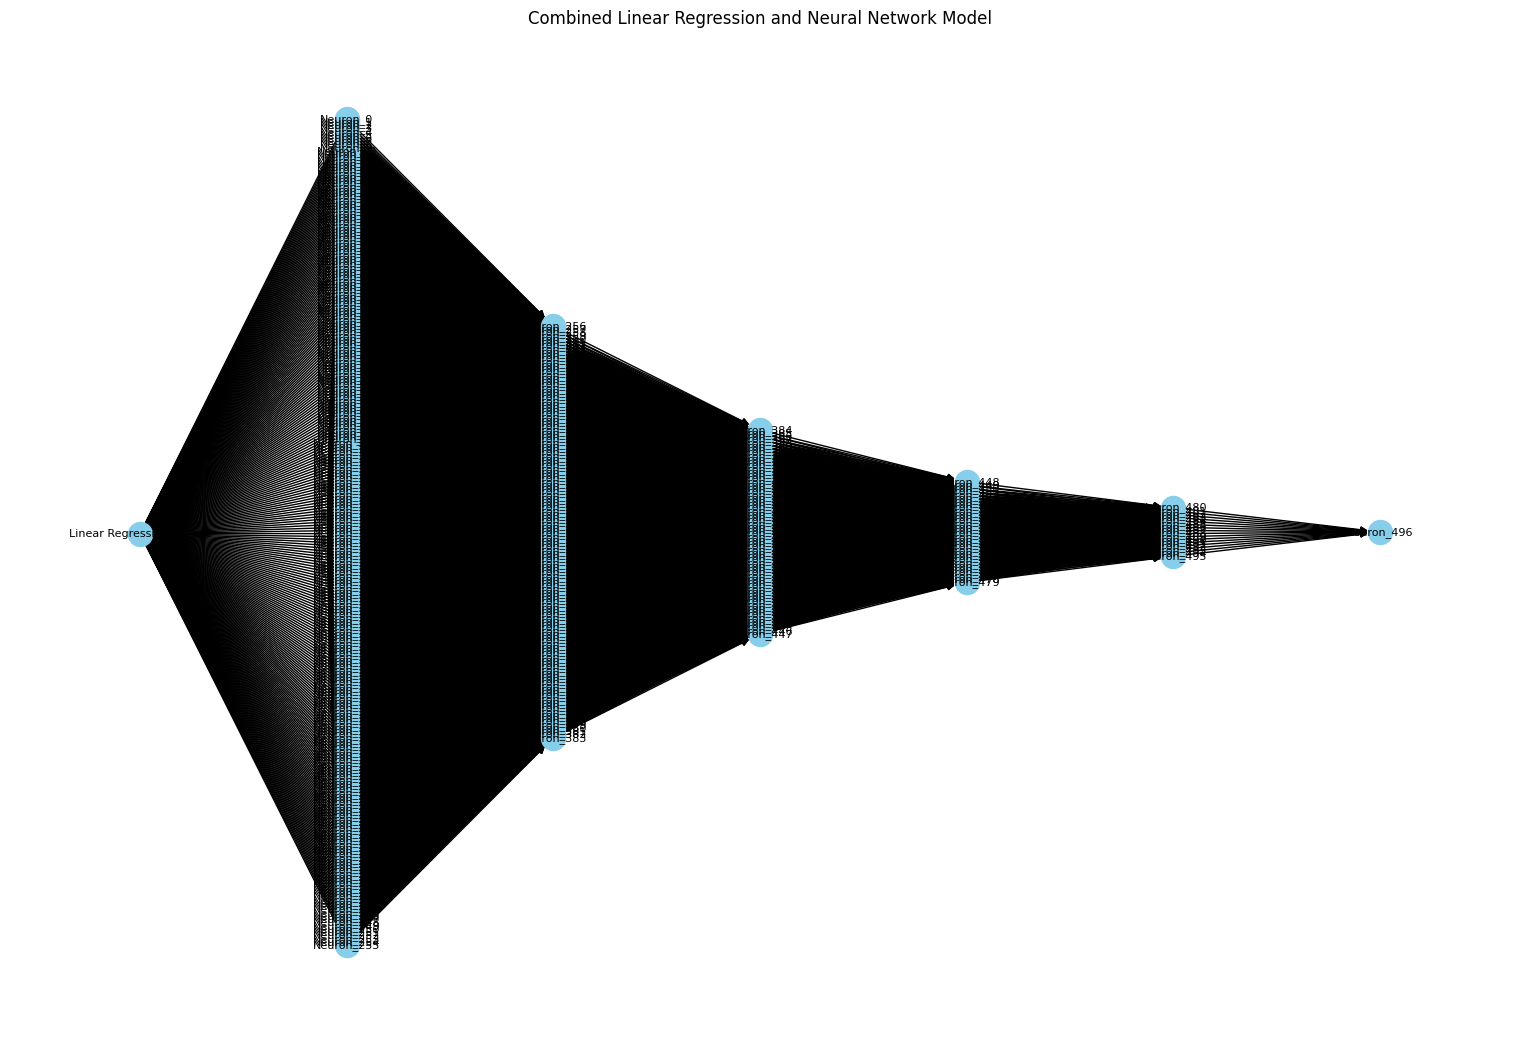

In [ ]:
import networkx as nx

G = nx.DiGraph()

G.add_node('Linear Regression Output', pos=(0, 0), layer=0)

input_size = X_train_nn.shape[1]
layer_sizes = [256, 128, 64, 32, 16, 1]
neuron_count = 0

horizontal_spacing = 2
vertical_spacing = 1

pos = {'Linear Regression Output': (0, 0)}
x_offset = 0

for i, size in enumerate(layer_sizes):
    x_offset += horizontal_spacing
    layer_height = size * vertical_spacing
    y_start = layer_height / 2
    for j in range(size):
        neuron_id = f'Neuron_{neuron_count}'
        pos[neuron_id] = (x_offset, y_start - j * vertical_spacing)
        G.add_node(neuron_id, layer=i+1)
        if i == 0:
            G.add_edge('Linear Regression Output', neuron_id)
        if i > 0:
            previous_layer_start = neuron_count - layer_sizes[i-1]
            for k in range(layer_sizes[i-1]):
                G.add_edge(f'Neuron_{previous_layer_start + k}', neuron_id)
        neuron_count += 1

plt.figure(figsize=(15, 10))
nx.draw(G, pos, with_labels=True, node_size=300, node_color='skyblue', font_size=8, font_color='black')
plt.title('Combined Linear Regression and Neural Network Model')
plt.axis('off')
plt.show()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model architecture saved as 'model_architecture.png'


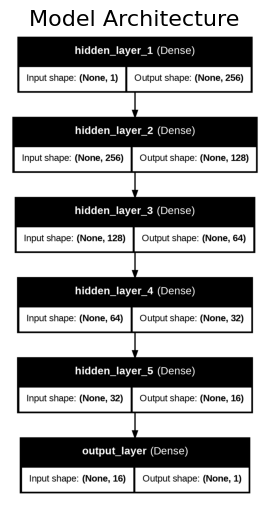

In [ ]:
model = Sequential([
    Dense(256, input_dim=1, activation='relu', name='hidden_layer_1'),
    Dense(128, activation='relu', name='hidden_layer_2'),
    Dense(64, activation='relu', name='hidden_layer_3'),
    Dense(32, activation='relu', name='hidden_layer_4'),
    Dense(16, activation='relu', name='hidden_layer_5'),
    Dense(1, activation='linear', name='output_layer')
])

plot_model(
    model,
    to_file="model_architecture.png",
    show_shapes=True,
    show_layer_names=True
)

print("Model architecture saved as 'model_architecture.png'")

img = plt.imread("model_architecture.png")
plt.figure(figsize=(6, 6))
plt.imshow(img)
plt.axis("off")
plt.title("Model Architecture", fontsize=16)
plt.show()
